# Introduction

Here is the code used for my blog post on graph neural networks. Feel free to use this as a starting point for your own work into the area.

Note that I would reccomend running this code in google colab as the `torch-geometric` library can be difficult to set up locally.

In [1]:
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-geometric

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # you will have to give access here

Mounted at /content/drive


In [ ]:
%matplotlib inline

import torch
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import data

In [ ]:
training_match_1 = pd.read_csv("data/training_match_1.csv")
training_match_2 = pd.read_csv("data/training_match_2.csv")
vaidation_match = pd.read_csv("data/vaidation_match.csv")
testing_match = pd.read_csv("data/testing_match.csv")
training_match_1.head()

,match_id,team_id,from_player_id,from_position,to_player_id,to_position,from_position_x,from_position_y,from_position_encoded
0,3795506,914,7788,Forward,3166,Midfield,60.0,40.0,1
1,3795506,914,3166,Midfield,11514,Defender,48.0,35.7,3
2,3795506,914,11514,Defender,7173,Defender,39.2,68.4,0
3,3795506,914,7173,Defender,6954,Defender,25.3,46.4,0
4,3795506,914,6954,Defender,7173,Defender,23.9,18.6,0


# Visualise a sample passing network

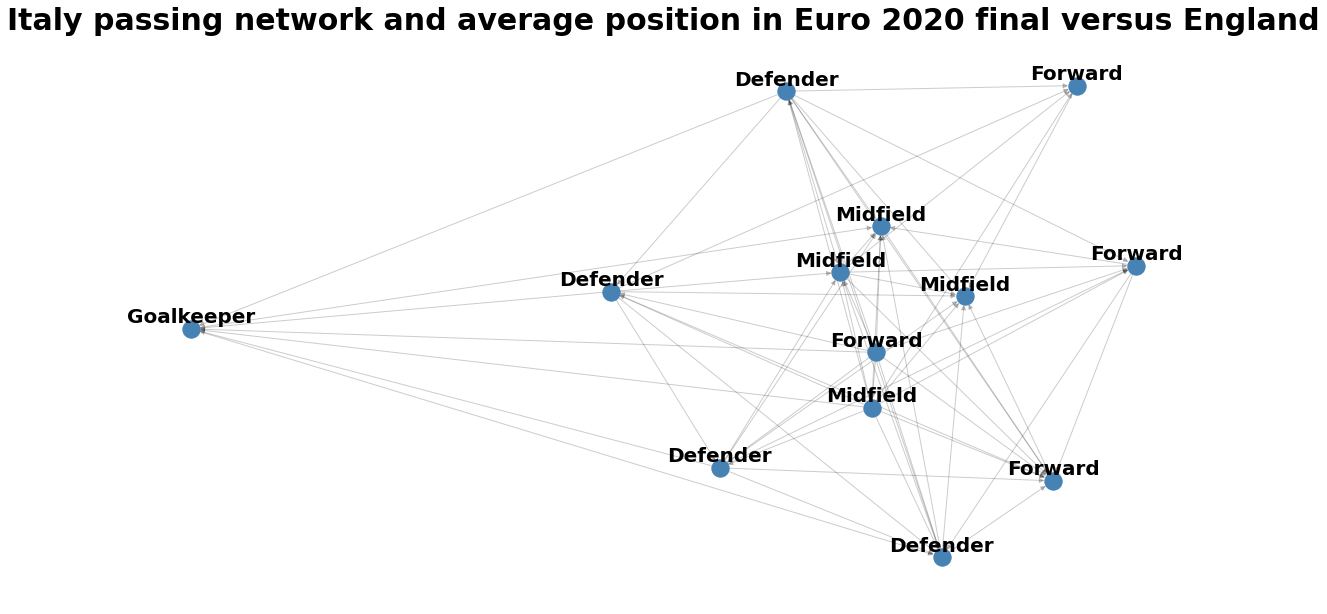

In [ ]:
G = nx.from_pandas_edgelist(training_match_1, source="from_player_id", target="to_player_id")
nodenames = {
    n:training_match_1.loc[
        training_match_1["from_player_id"]==n, "from_position"
    ].iloc[0] for n in G.nodes()
}

pos = {
    n:list(training_match_1.loc[
        training_match_1["from_player_id"]==n, ["from_position_x", "from_position_y"]
    ].mean()) for n in G.nodes()
}

fig, ax = plt.subplots()
fig.set_size_inches(20.5, 10.5)



nx.draw_networkx_nodes(G, pos, node_color='steelblue')
nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.2)

# draw the labels just above the nodes
label_pos = pos
for key in pos:
  label_pos[key][1] += 1.5
nx.draw_networkx_labels(G, pos=label_pos, labels=nodenames, font_size=20, font_weight="bold")


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Italy passing network and average position in Euro 2020 final versus England", fontsize=30, fontweight='bold')
plt.savefig('/content/drive/MyDrive/ColabNotebooks/visuals/example_game_network.png')
plt.show()

# Convert passing networks into GNN training format

In [ ]:
def create_graph_from_dataframe(dataframe: pd.DataFrame):
  # first create a network x representation of the graph from the pandas dataframe
  match_network_x_graph = nx.from_pandas_edgelist(
      dataframe, source="from_player_id", target="to_player_id"
  )

  # then convert that to a pytorch geometric graph
  graph_for_modelling = from_networkx(match_network_x_graph)


  # create our x features (player mean passing positions)
  graph_for_modelling.x = torch.tensor(
    list(
      {
          n:list(dataframe.loc[
              dataframe["from_player_id"]==n, 
              ["from_position_x", "from_position_y"]
          ].mean()) for n in match_network_x_graph.nodes()
      }.values()), 
      dtype=torch.float
  )/100

  # create our y (target) features
  graph_for_modelling.y = torch.tensor([
      dataframe.loc[
        dataframe["from_player_id"]==n, "from_position_encoded"
    ].iloc[0] for n in match_network_x_graph.nodes()
  ], dtype=torch.long)

  # ensure the edge_index is of the correct datatype
  graph_for_modelling.edge_index = graph_for_modelling.edge_index.type(
      torch.LongTensor
  )

  # add the player id as a feature to help us when plotting later
  graph_for_modelling.player_id = [n  for n in match_network_x_graph.nodes()] 

  return graph_for_modelling

In [ ]:
modelling_train = [create_graph_from_dataframe(match) for match in [training_match_1, training_match_2]]
modelling_train

[Data(edge_index=[2, 122], num_nodes=13, x=[13, 2], y=[13], player_id=[13]),
 Data(edge_index=[2, 72], num_nodes=10, x=[10, 2], y=[10], player_id=[10])]

In [ ]:
modelling_val = create_graph_from_dataframe(vaidation_match)
modelling_val

Data(edge_index=[2, 96], num_nodes=11, x=[11, 2], y=[11], player_id=[11])

In [ ]:
modelling_test = create_graph_from_dataframe(testing_match)
modelling_test

Data(edge_index=[2, 120], num_nodes=12, x=[12, 2], y=[12], player_id=[12])

# Modelling

## Class defining the model architecture

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

NUM_FEATURES = modelling_train[0].x.shape[1]
NUM_CLASSES = len(training_match_1["from_position_encoded"].drop_duplicates())
HIDDEN_LAYER_SIZE = 256
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Model layers
        self.conv1 = SAGEConv(NUM_FEATURES, HIDDEN_LAYER_SIZE)
        self.lin_1 = Linear(HIDDEN_LAYER_SIZE, NUM_CLASSES*4)
        self.lin_2 = Linear(NUM_CLASSES*4, NUM_CLASSES)


    def forward(self, data):
        # The architecture itself
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin_2(x)

        return F.log_softmax(x, dim=1)

## Train and evaluate the model

In [ ]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train_model(train_data):
    model.train()
    for data in train_data:
      out = model(data) # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.

    return model

def evaluate_model(test_data):
    model.eval()
    correct = 0
    total_samples = 0

    model_outputs = []
    targets = []
    for data in test_data:
      model_output = model(data)
      predicted_class = model_output.argmax(dim=1) 

      correct += int((predicted_class == data.y).sum())
      total_samples += len(data.y)

      # store these to get the loss
      model_outputs.extend(model_output.tolist())
      targets.extend(data.y.tolist())

    accuracy = correct/total_samples
    loss = criterion(torch.tensor(model_outputs), torch.tensor(targets))

    return accuracy, loss



train_accuraacies = []
validation_accuraacies = []
validation_losses = []
train_losses = []
for epoch in range(1, 3000):
    train_accuracies = []
    model = train_model(modelling_train)

    train_acc, train_loss = evaluate_model(modelling_train)
    train_losses.append(train_loss)
    val_acc, val_loss = evaluate_model([modelling_val])
    validation_losses.append(val_loss)


    train_accuraacies.append(train_acc)
    validation_accuraacies.append(val_acc)

    # save the model if it is the better than any previous ones
    if val_loss.item() <= min(validation_losses).item():
      torch.save(model, "/content/drive/MyDrive/ColabNotebooks/best_model.pkl")
    if epoch % 50 == 0:
      print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

best_validation_loss = min(validation_losses)
best_epoch = validation_losses.index(best_validation_loss)
accuracy_at_best_epoch = validation_accuraacies[best_epoch]
print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch} and a loss of {best_validation_loss}")

Epoch: 50, Train Acc: 0.4783, Train Loss: 0.4783, Val Acc: 0.4545, Val Loss: 1.1851
Epoch: 100, Train Acc: 0.5652, Train Loss: 0.5652, Val Acc: 0.4545, Val Loss: 1.0457
Epoch: 150, Train Acc: 0.5652, Train Loss: 0.5652, Val Acc: 0.5455, Val Loss: 0.9324
Epoch: 200, Train Acc: 0.7391, Train Loss: 0.7391, Val Acc: 0.7273, Val Loss: 0.8794
Epoch: 250, Train Acc: 0.7391, Train Loss: 0.7391, Val Acc: 0.7273, Val Loss: 0.8635
Epoch: 300, Train Acc: 0.6957, Train Loss: 0.6957, Val Acc: 0.8182, Val Loss: 0.8118
Epoch: 350, Train Acc: 0.6957, Train Loss: 0.6957, Val Acc: 0.5455, Val Loss: 0.7905
Epoch: 400, Train Acc: 0.7826, Train Loss: 0.7826, Val Acc: 0.6364, Val Loss: 0.7261
Epoch: 450, Train Acc: 0.7391, Train Loss: 0.7391, Val Acc: 0.7273, Val Loss: 0.7600
Epoch: 500, Train Acc: 0.7391, Train Loss: 0.7391, Val Acc: 0.6364, Val Loss: 0.6761
Epoch: 550, Train Acc: 0.7391, Train Loss: 0.7391, Val Acc: 0.7273, Val Loss: 0.6740
Epoch: 600, Train Acc: 0.7826, Train Loss: 0.7826, Val Acc: 0.8182

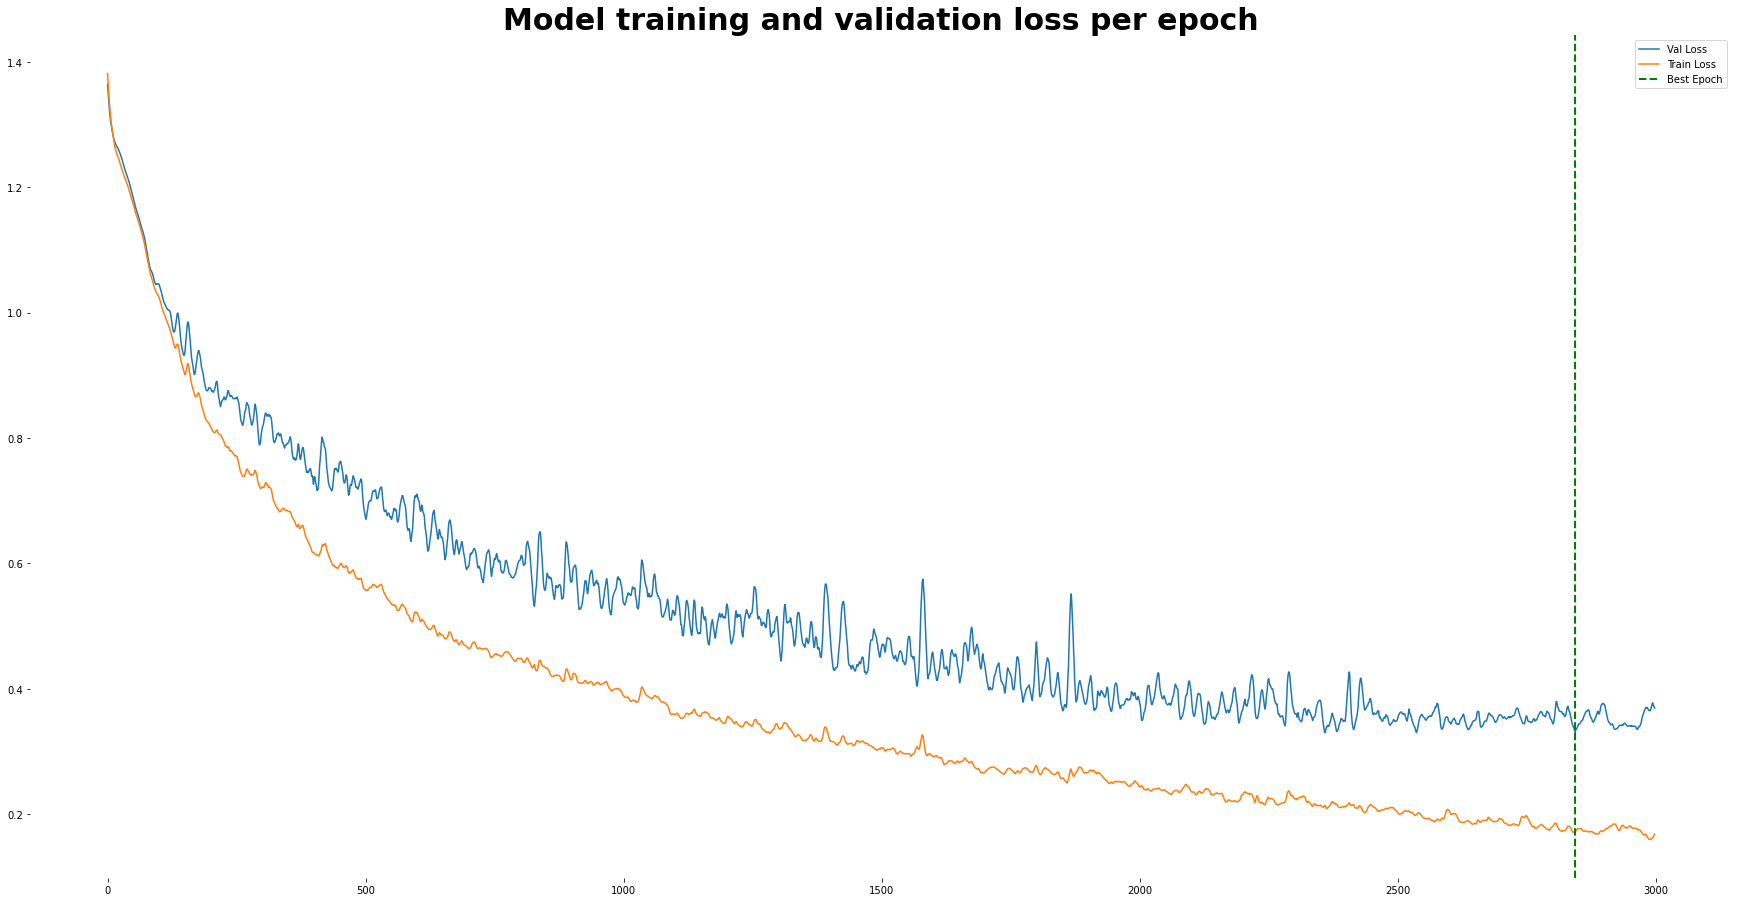

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

plt.plot(validation_losses)
plt.plot(train_losses)
plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed')
plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Model training and validation loss per epoch", fontsize=30, fontweight='bold')
plt.savefig('model_loss.png')
plt.show()

# Make some predictions on the test set

In [ ]:
# load the model
best_model = torch.load("best_model.pkl")

# predict the output
model_output = model(modelling_test)
predicted_class = model_output.argmax(dim=1) 

# calculate the accuracy
int((predicted_class == modelling_test.y).sum())/len(modelling_test.y)

In [ ]:
# map the predicted and actual classes to the class name
predicted_class_names = []

for i in range(len(predicted_class)):
  
  predicted_class_names.append(
      testing_match.loc[
        testing_match["from_position_encoded"]==predicted_class[i].item(), 
        "from_position"
      ].iloc[0]
  )
  i+=1  

modelling_test.predicted_class_name = predicted_class_names
modelling_test.predicted_class_name

['Defender',
 'Midfield',
 'Midfield',
 'Forward',
 'Defender',
 'Forward',
 'Defender',
 'Forward',
 'Forward',
 'Midfield',
 'Goalkeeper',
 'Forward']

## Visualise the predictions

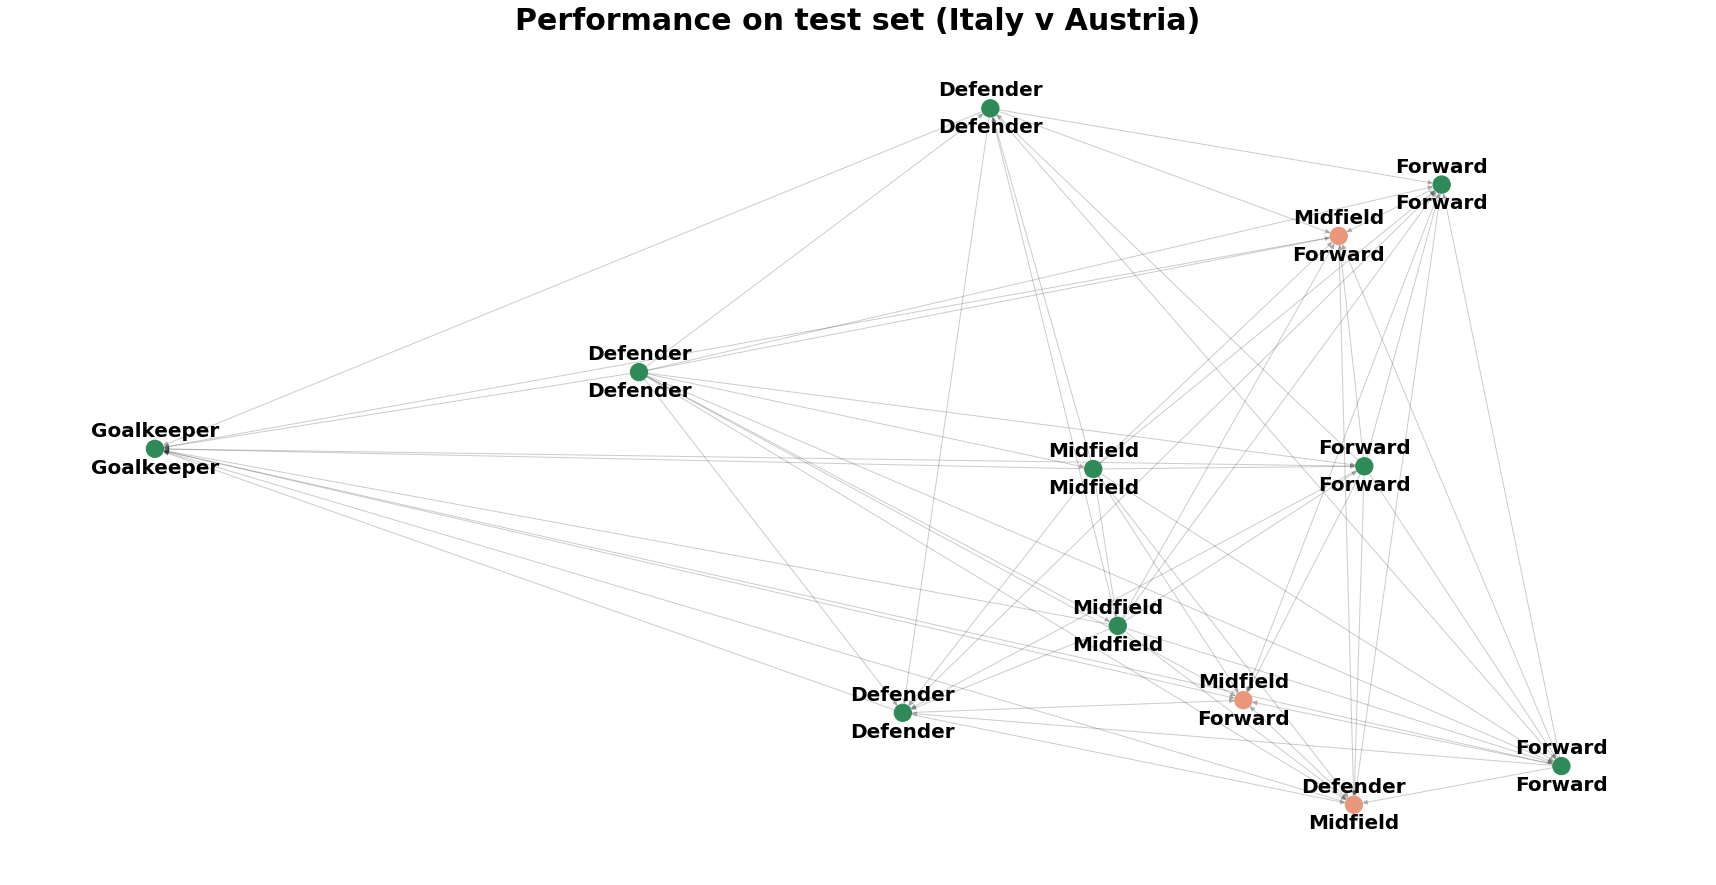

In [ ]:
import copy

G = nx.from_pandas_edgelist(testing_match, source="from_player_id", target="to_player_id")
actual_position = {
    n:testing_match.loc[
        testing_match["from_player_id"]==n, "from_position"
    ].iloc[0] for n in G.nodes()
}

# create a dict of the player ID and the predicted class (this will help with visualisng the data)
predicted_positions = {}
for i in range(len(modelling_test.predicted_class_name)):
  predicted_positions[modelling_test.player_id[i]] = modelling_test.predicted_class_name[i]

# get the average position to plot on the x and y
average_position = {
    n:list(testing_match.loc[
        testing_match["from_player_id"]==n, ["from_position_x", "from_position_y"]
    ].mean()) for n in G.nodes()
}

fig, ax = plt.subplots()
fig.set_size_inches(30.5, 15.5)

# colour the nodes based on prediction (green_correct, red incorrect)
node_colours = []
for n in G.nodes():
  node_colours.append("seagreen" if actual_position[n] == predicted_positions[n] else "darksalmon")

nx.draw_networkx_nodes(G, average_position, node_color=node_colours)
nx.draw_networkx_edges(G, average_position, arrows=True, alpha=0.2)

# draw the labels just above and below the nodes
actual_label_pos = copy.deepcopy(average_position)
predicted_label_pos = copy.deepcopy(average_position)
for key in average_position:
  actual_label_pos[key][1] += 1.5
  predicted_label_pos[key][1] -= 1.5

nx.draw_networkx_labels(G, pos=actual_label_pos, labels=actual_position, font_size=20, font_weight="bold")
nx.draw_networkx_labels(G, pos=predicted_label_pos, labels=predicted_positions, font_size=20, font_weight="bold")


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title("Performance on test set (Italy v Austria)", fontsize=30, fontweight='bold')
plt.savefig('test_set_performance.png')
plt.show()